# Hierarchical Clustering
Author: George H. Chen (georgechen [at symbol] cmu.edu)

Part of this demo uses the [random color map code created by Felipe Delestro Matos](https://github.com/delestro/rand_cmap).

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

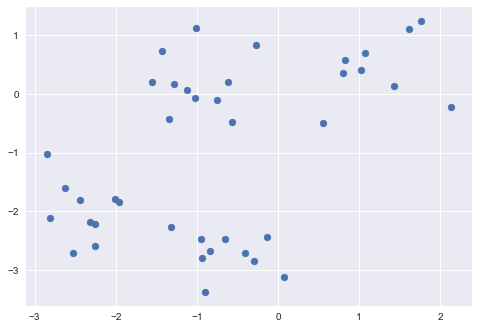

In [11]:
# manually create 4 clusters
# (note that this is actually a 4-cluster Gaussian mixture model!)

np.random.seed(0)

points_cluster1 = .5*np.random.randn(10, 2) + np.array([-1.5, 0])[np.newaxis, :]
points_cluster2 = .5*np.random.randn(10, 2) + np.array([1, 0.5])[np.newaxis, :]
points_cluster3 = .5*np.random.randn(10, 2) + np.array([-2, -2])[np.newaxis, :]
points_cluster4 = .5*np.random.randn(10, 2) + np.array([-0.5, -2.5])[np.newaxis, :]

points = np.vstack([points_cluster1,
                    points_cluster2,
                    points_cluster3,
                    points_cluster4])

plt.scatter(points[:, 0], points[:, 1])

## Divisive clustering


The code below uses highest cluster RSS to decide which cluster to split next, and uses k-means (with k=2) to do the actual split. We stop the algorithm after 3 splits.

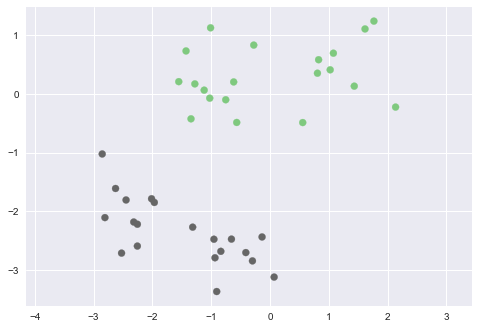

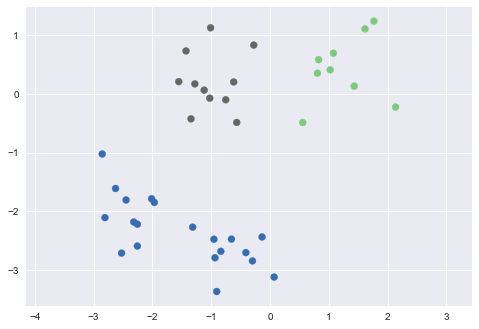

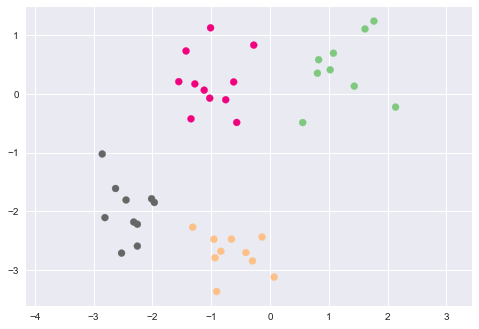

In [12]:
from sklearn.cluster import KMeans

cluster_assignment = np.zeros(len(points)).astype(np.int)  # everything starts off being in cluster 0

num_splits = 3  # really simple stopping rule: stop after doing 3 splits (so we end up with 4 clusters)

for split_idx in range(num_splits):
    # select which cluster to split by looking at which one has the highest residual sum of squares (RSS)
    num_clusters = cluster_assignment.max() + 1
    max_cluster_RSS = -np.inf
    arg_max = None
    for cluster_idx in range(num_clusters):
        # compute cluster's Residual Sum of Squares (RSS)
        cluster_mask = (cluster_assignment == cluster_idx)
        cluster_size = cluster_mask.sum()
        if cluster_size == 1:
            cluster_RSS = 0.
        else:
            points_in_cluster = points[cluster_mask]
            cluster_mean = points_in_cluster.mean(axis=0)
            cluster_RSS = 0.
            for point in points_in_cluster:
                cluster_RSS += np.linalg.norm(point - cluster_mean)**2
                
        if cluster_RSS > max_cluster_RSS:
            max_cluster_RSS = cluster_RSS
            arg_max = cluster_idx
            
    # split cluster with largest cluster RSS (arg_max)
    kmeans = KMeans(n_clusters=2, n_init=1000, random_state=0)
    split_assignments = kmeans.fit_predict(points[cluster_assignment == arg_max])
    # every point assigned to k-mean's output cluster 0 will be set to still have cluster index `arg_max`
    # whereas every point assigned to k-mean's output cluster 1 will be set to have cluster index `num_clusters`
    cluster_assignment[cluster_assignment == arg_max] \
        = arg_max * (split_assignments == 0) + num_clusters * (split_assignments == 1)  # create new cluster
    
    plt.figure()
    plt.scatter(points[:, 0], points[:, 1], c=cluster_assignment, cmap='Accent')
    plt.axis('equal')

## Agglomerative clustering

###  The simple way using sklearn (but the functionality is limited)

To see what scikit-learn is capable of, look up the documentation for `AgglomerativeClustering`.

(-3.111160267649148, 2.392902484330446, -3.60590945099776, 1.477447534782064)

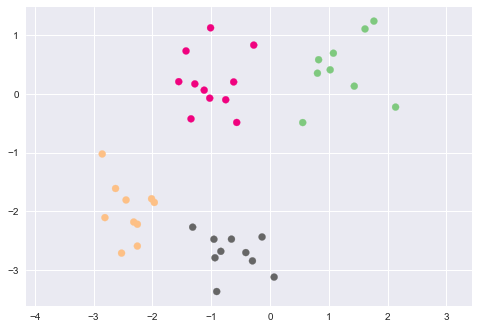

In [15]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
cluster_assignments = clustering.fit_predict(points)
plt.scatter(points[:, 0], points[:, 1], c=cluster_assignments, cmap='Accent')
plt.axis('equal')

### Agglomerative clustering without scikit-learn

For simplicity, the following code keeps merging until there's exactly 1 cluster, and at each merge step, the code plots what the clusters are. Because the number of clusters can be quite large, we use a random coloring for each plot; we specifically use the [random color map created by Felipe Delestro Matos](https://github.com/delestro/rand_cmap).

We demonstrate this code using a simple line of points evenly spaced apart; feel free to comment out the next cell if you want to run the algorithm on the random points from earlier in this demo.

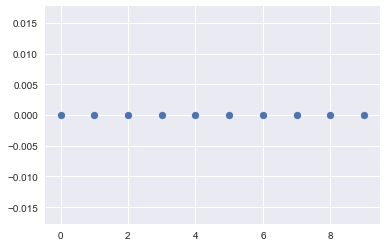

In [5]:
points = np.vstack([np.arange(10), np.zeros(10)]).T

plt.scatter(points[:, 0], points[:, 1])

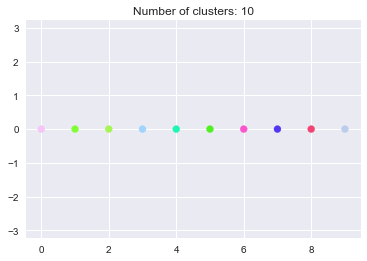

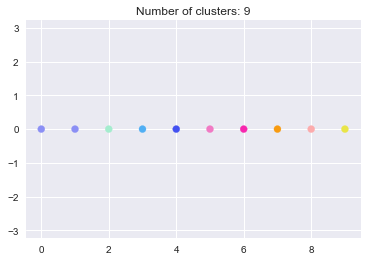

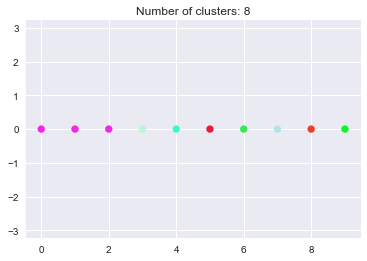

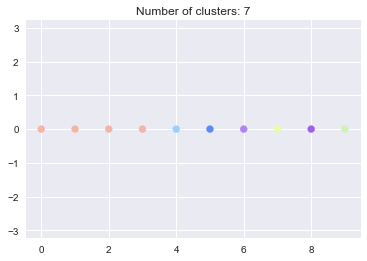

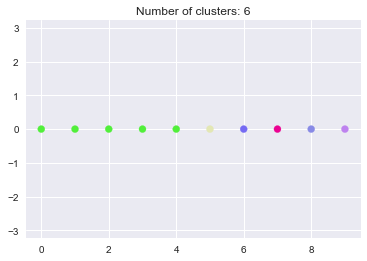

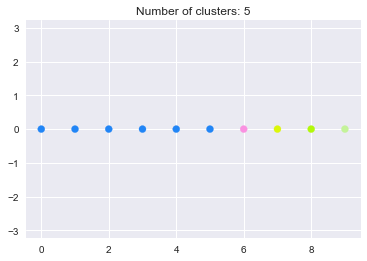

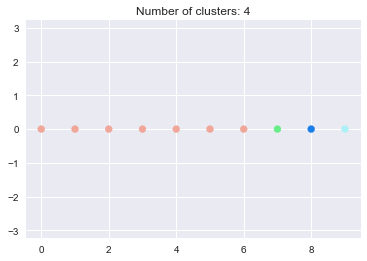

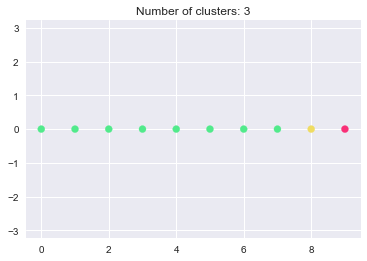

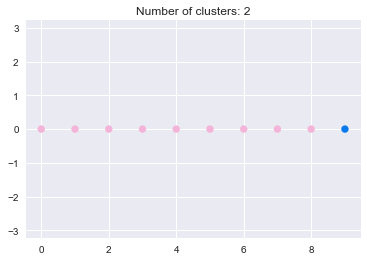

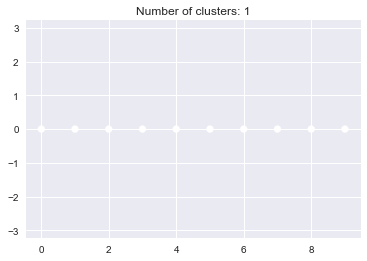

In [6]:
num_clusters = len(points)

cluster_assignment = np.arange(num_clusters).astype(np.int)

from scipy.spatial.distance import cdist
from rand_cmap import rand_cmap

plt.figure()
plt.title('Number of clusters: ' + str(num_clusters))
plt.scatter(points[:, 0], points[:, 1], c=cluster_assignment,
            cmap=rand_cmap(num_clusters, type='bright',
                           first_color_black=False,
                           last_color_black=False,
                           verbose=False))
plt.axis('equal')

linkage = 'single'

while num_clusters > 1:
    # find the two clusters that are ``closest'' according to some rule
    min_dist = np.inf
    arg_min = None
    for cluster_idx1 in range(num_clusters):
        cluster1_points = points[cluster_assignment == cluster_idx1]
        for cluster_idx2 in range(cluster_idx1 + 1, num_clusters):
            cluster2_points = points[cluster_assignment == cluster_idx2]
            
            if linkage == 'centroid':
                dist = np.linalg.norm(cluster1_points.mean(axis=0)
                                      - cluster2_points.mean(axis=0))
            elif linkage == 'single':
                dist = cdist(cluster1_points, cluster2_points).min()
            elif linkage == 'complete':
                dist = cdist(cluster1_points, cluster2_points).max()
            else:
                raise NotImplementedError('Unsupported linkage type')
            
            if dist < min_dist:
                min_dist = dist
                arg_min = (cluster_idx1, cluster_idx2)
                
    cluster_idx1, cluster_idx2 = arg_min
    
    # merge arg_min clusters
    cluster_assignment[cluster_assignment == cluster_idx2] = cluster_idx1
    mask = (cluster_assignment > cluster_idx2)
    if mask.sum() > 0:
        cluster_assignment[mask] -= 1
    num_clusters -= 1
    
    plt.figure()
    plt.title('Number of clusters: ' + str(num_clusters))
    if num_clusters > 1:
        plt.scatter(points[:, 0], points[:, 1], c=cluster_assignment,
                    cmap=rand_cmap(num_clusters, type='bright',
                                   first_color_black=False,
                                   last_color_black=False,
                                   verbose=False))
    else:
        plt.scatter(points[:, 0], points[:, 1], c=cluster_assignment)
    plt.axis('equal')